In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [ ]:
#I guess do this for now?
#tf.config.run_functions_eagerly(False)

# Load images

Right now the 4 class mask is a jpg, and what this u-net model appears to predict is a grayscale $d\times d$ image with pixel values in $\{0,1,2,3\}$. I think that's gross and I would rather predict a boolean $d\times d\times 4$ image.

In [119]:
#load/preprocess.

POINTS1=np.float32([[215,40],[895,65],[305,810],[930,780]])
SIZE = 700
POINTS2 = np.float32([[0,0],[SIZE,0],[0,SIZE],[SIZE,SIZE]])
DIM=(1149,853)

M = cv.getPerspectiveTransform(POINTS1,POINTS2)
#gray_mask = cv.warpPerspective(pre_gray_mask,M,(700,700))

def load_marsh_images(folder):
    images = []
    
    for i in range(1,12):
        img = cv.imread(os.path.join(folder,"Band%d.jpg" % i))
        print("Band%d.jpg" % i)
        if img is not None:
            #convert to black and white
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            #warp so the mask is square
            img = cv.warpPerspective(img,M,(SIZE,SIZE))
            images.append(img)
        
        #do same for mask
        #marsh_mask = cv.imread("marsh_mask.jpg")
        #marsh_mask = cv.cvtColor(marsh_mask, cv.COLOR_BGR2GRAY)
        
        #try mask from 4class
        marsh_mask = cv.imread("new-masks/4class_mask.jpg")
        #marsh_mask = cv.cvtColor(marsh_mask, cv.COLOR_BGR2GRAY)
        marsh_mask = cv.resize(marsh_mask, DIM, interpolation = cv.INTER_AREA)
        marsh_mask = cv.warpPerspective(marsh_mask,M,(700,700))
        
    images = np.array(images)

    return images,marsh_mask
    
    #for filename in os.listdir(folder):
    #    img = cv.imread(os.path.join(folder,filename))
    #    if img is not None:
    #        images.append(img)
    #return images




In [117]:
#process marsh images 

marsh_images_gray,gray_mask = load_marsh_images("train_jpg")
#try converting to greyscale 


Band1.jpg
Band2.jpg
Band3.jpg
Band4.jpg
Band5.jpg
Band6.jpg
Band7.jpg
Band8.jpg
Band9.jpg
Band10.jpg
Band11.jpg


In [7]:
marsh_images_gray.shape

(11, 700, 700)

(700, 700)

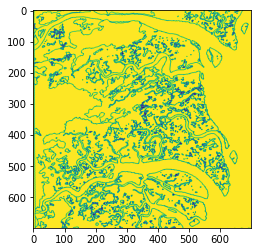

In [118]:
#convert to grayscale 
#gray_marsh = cv.cvtColor(marsh_images[7], cv.COLOR_BGR2GRAY)
#plt.imshow(gray_marsh)
plt.imshow(gray_mask)
gray_mask.shape#,four_class_mask.shape


# New mask files 

In [16]:
mask_dict = {}
mask_dict["land_mask"] = cv.imread("new-masks/land_mask.jpg")
mask_dict["marsh_mask"] = cv.imread("new-masks/marsh_mask.jpg")
mask_dict["pond_mask"] = cv.imread("new-masks/pond_mask.jpg")
mask_dict["openwater_mask"] = cv.imread("new-masks/openwater_mask.jpg")
four_class_mask = cv.imread("new-masks/4class_mask.jpg")





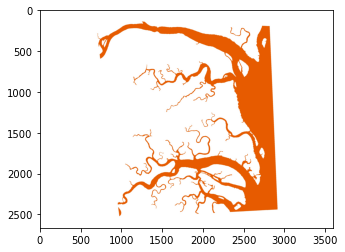

In [7]:
plt.imshow(mask_dict["openwater_mask"])

# Preliminary attempt 

Use many crops of the images/labels as training data for u-nets. Train to guess boundary or not boundary (at first). 

Issues to be solved: 

1. The solutions need to be stiched together somehow. 
2. The solution does not automatically output a curve - the boundary can be wider than 1.
3. The solution does not know what is marsh, water, etc. A solution to this might be to instead output three classes, then compare the boundary.
4. The mask only covers part of the image and has a weird shape. Also the parallelogram is included, which it shouldn't be. I think the right thing to do is to somehow mask off what's outside the parallelogram. 
5. Can't use any pre-trained u-net out of the box because of the extra image bands - need one with enough channels.


## Second attempt 

1. Use the 4 class mask instead of just predicting boundaries
2. See if patching is unecessary - can the network make predictions on different image sizes than the input? Intuitively yes since everything is just conv or conv2d.
3. Visualize with tensorboard to systematically see what parameter tunings make a difference.
4. Try a much shallower net.

## Extracting patches

In [21]:




def get_patches(img_list,patch_size,patch_stride,mask=False):
    
    image = tf.convert_to_tensor(img_list, dtype =tf.float32)/255.0
    
    
    if mask:
        HEIGHT,WIDTH,BANDS = image.shape
        reshaped_image = tf.reshape(image,[1,HEIGHT,WIDTH,BANDS])
    else:
        BANDS,HEIGHT,WIDTH = image.shape
        reshaped_image = tf.transpose(image, perm=[1,2,0])
        reshaped_image = tf.reshape(reshaped_image,[1,HEIGHT,WIDTH,BANDS])



    patches = tf.image.extract_patches(images=reshaped_image,
                               sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
                               strides=[1, PATCH_STRIDE, PATCH_STRIDE, 1],
                               rates=[1, 1, 1, 1],
                               padding='VALID')

    patches = tf.reshape(patches,[-1,PATCH_SIZE,PATCH_SIZE,BANDS])
   
    
    
    return patches 



    

In [122]:
#marsh_images_gray[:,:500,:].shape
#gray_mask[:500,:].shape

(500, 700)

In [22]:
PATCH_SIZE = 128
PATCH_STRIDE = 10

patches = get_patches(marsh_images_gray[:,:500,:],PATCH_SIZE,PATCH_STRIDE)
mask_patches = get_patches(gray_mask[:500,:],PATCH_SIZE,PATCH_STRIDE,mask=True)

test_patches = get_patches(marsh_images_gray[:,500:,:],PATCH_SIZE,PATCH_STRIDE)
test_mask = get_patches(gray_mask[500:,:],PATCH_SIZE,PATCH_STRIDE,mask=True)



(464, 128, 128, 11) (464, 128, 128, 3)
(2204, 128, 128, 11) (2204, 128, 128, 3)


<Figure size 432x288 with 0 Axes>

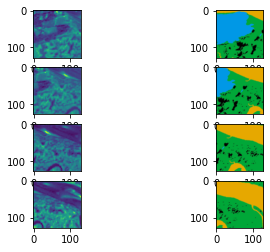

In [27]:
#make sure they line up
plt.figure()

f, axarr = plt.subplots(4,2) 

for i in range(4):
    axarr[i][0].imshow(patches.numpy()[200 + 5*i,:,:,7])
    axarr[i][1].imshow(mask_patches.numpy()[200 + 5*i,:,:])
print(test_patches.shape,test_mask.shape)
print(patches.shape,mask_patches.shape)

## Training from patches 

In [28]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output



In [13]:
mask_patches.shape

TensorShape([2204, 128, 128, 1])

In [29]:
#do a 50-50 split for now - top half of image
#TRAIN_RATIO = 2
#TRAIN_LENGTH = num_patches//TRAIN_RATIO
BATCH_SIZE = 64
BUFFER_SIZE = 100
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [30]:
#define train_images 

#I need to convert to a tensorflow dataset, I guess. 

#so right now I just have a big tensor. Need to say X_train = one part, y_train = another part.

#patches.shape

patch_dataset = tf.data.Dataset.from_tensor_slices((patches,mask_patches))

#patch_dataset

test_dataset = tf.data.Dataset.from_tensor_slices((test_patches,test_mask))

In [31]:
#batches

#try it without shuffling - this may be causing leakage

train_batches = (
    patch_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    #.repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)

# Creating the model
I used the same neural network from the tutorial but with a 1x1 convolution to change the number of channels.

In [32]:
#tried to use mobilenet with more channels, got issues.

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [33]:
# try to implement mobilenet (or something like it) myself. 
# for now just try to guess if mask/not mask?
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [34]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 11])

    #try to do a 1x1 convolution to get it down to size.
    #reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
    reduce_channel = tf.keras.layers.Conv2D(3,1,1,activation="relu")(inputs)
  # Downsampling through the model
    #skips = down_stack(inputs)
    skips = down_stack(reduce_channel)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [40]:
OUTPUT_CLASSES = 4

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 11 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 3)  36          input_2[0][0]                    
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     conv2d[0][0]                     
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
____________________________________________________________________________________________

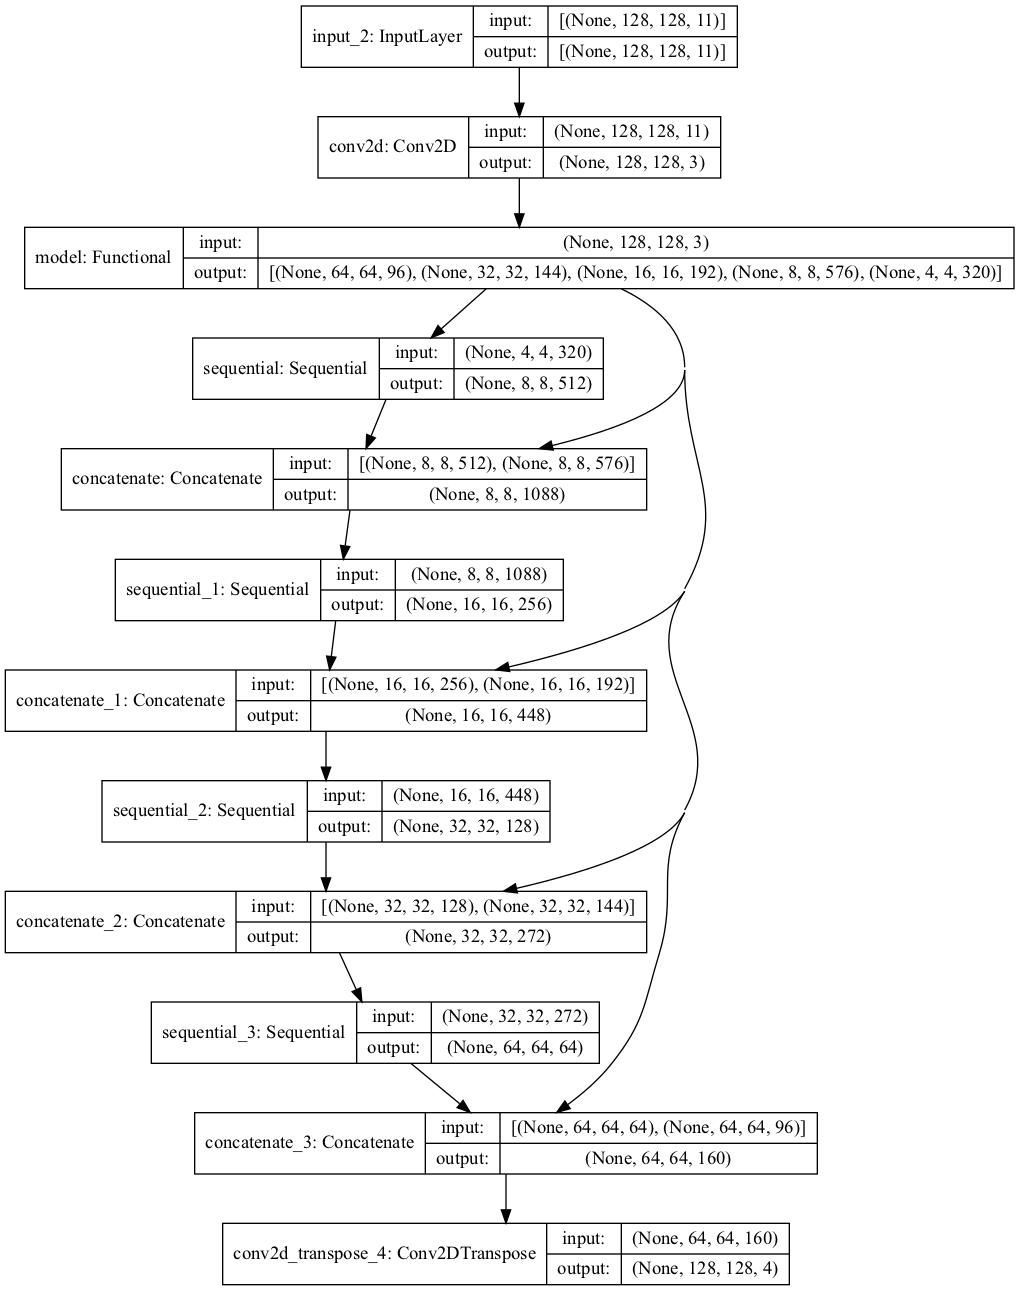

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Testing the model

Try out the model to check what it predicts before training.

In [37]:
#for images, masks in train_batches.take(2):
#  sample_image, sample_mask = images[0], masks[0]
#  display([sample_image, sample_mask])

for patch,mask in patch_dataset.skip(10).take(1):
    sample_image,sample_mask = patch, mask
#for mask in mask_dataset.take(40):
#    sample_mask = mask



In [35]:
#to show the 
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
def show_predictions_loaded(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = loaded_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(loaded_model.predict(sample_image[tf.newaxis, ...]))])
    
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i][:,:,:3]))
    plt.axis('off')
  plt.show()

2022-02-20 23:53:46.008853: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-20 23:53:46.155949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


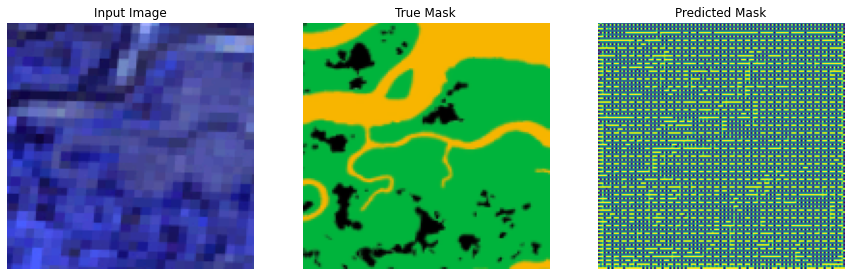

In [43]:
#im = patch[:,:,:3]
#im.shape
show_predictions()

#wow, it actually does something!!! 

# Training the model

Going to give it a shot. 

In [44]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [45]:
EPOCHS = 1000
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS



model_history = model.fit(train_batches, epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()]
                         )

Epoch 1/1000


2022-02-20 23:54:09.994080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


InvalidArgumentError: 2 root error(s) found.
  (0) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [1048576,4] and labels shape [3145728]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/backend.py:4956)
]]
	 [[Equal/_21]]
  (1) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [1048576,4] and labels shape [3145728]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/backend.py:4956)
]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_10546]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] sparse_categorical_crossentropy/Reshape_1 (defined at /Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/backend.py:4952)	
In[1] sparse_categorical_crossentropy/Reshape (defined at /Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/backend.py:3406)

Operation defined at: (most recent call last)
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/var/folders/7j/6jzwjcln5ll_26fn_gz33j3c0000gn/T/ipykernel_13068/3551850756.py", line 7, in <module>
>>>     model_history = model.fit(train_batches, epochs=EPOCHS,
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 1184, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 853, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 842, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 835, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 788, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/losses.py", line 1738, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/backend.py", line 4956, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Input Source operations connected to node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] sparse_categorical_crossentropy/Reshape_1 (defined at /Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/backend.py:4952)	
In[1] sparse_categorical_crossentropy/Reshape (defined at /Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/backend.py:3406)

Operation defined at: (most recent call last)
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/var/folders/7j/6jzwjcln5ll_26fn_gz33j3c0000gn/T/ipykernel_13068/3551850756.py", line 7, in <module>
>>>     model_history = model.fit(train_batches, epochs=EPOCHS,
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 1184, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 853, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 842, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 835, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 788, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/losses.py", line 1738, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/backend.py", line 4956, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Function call stack:
train_function -> train_function


In [ ]:
# it does seem to be doing way better. but why is it oscillating between epochs? 
#I think we need to do something about the issue with some having masks and some not
#also we need to look at test data, not just data that's used to train 

# Save the model



In [53]:
model.save('saved-model-unweighted')

2022-02-14 20:18:28.197502: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved-model-unweighted/assets


/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [31]:
#loading model?
loaded_model = tf.keras.models.load_model('saved-model-unweighted')

2022-02-14 14:40:14.819580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


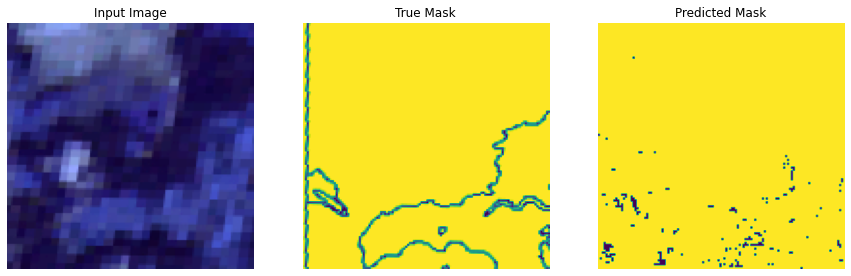

In [32]:
show_predictions_loaded()

# Weighted model

Currently broken.

In [39]:
#first inspect
for patch,mask in test_dataset.skip(20).take(1):
    sample_image,sample_mask = patch, mask
    show_predictions_weighted()

NameError: name 'show_predictions_weighted' is not defined

In [21]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 1.0,])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [78]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [23]:
OUTPUT_CLASSES = 2
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [24]:
def show_predictions_weighted(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = weighted_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(weighted_model.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback_weighted(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #if epoch % 3 == 0:
    clear_output(wait=True)
    show_predictions_weighted()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


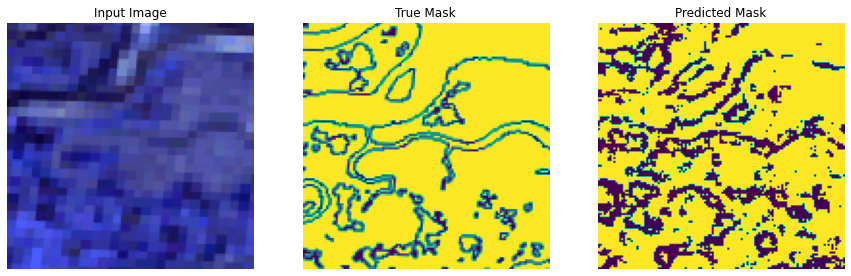


Sample Prediction after epoch 500

Epoch 501/1000
13/35 [==========>...................] - ETA: 13s - loss: 0.0547 - accuracy: 0.7997

In [ ]:
EPOCHS = 1000
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS



weighted_model_history = weighted_model.fit(train_batches.map(add_sample_weights), epochs=EPOCHS,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback_weighted()]
                         )

In [59]:
for patch,mask in test_dataset.skip(10).take(1):
    sample_image,sample_mask = patch, mask
    show_predictions_weighted()

NameError: name 'show_predictions_weighted' is not defined

In [59]:
# big question - is there data leakage?
model.save('saved-model-transformed')

2022-02-12 00:09:49.960048: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved-model-transformed/assets


/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Predicting on a different size image. 

Just putting in a new image doesn't work. 

Everything is convolutional, so we should just be able to resize the model.



In [55]:
model = tf.keras.models.load_model('saved-model')

2022-02-21 15:17:36.741120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


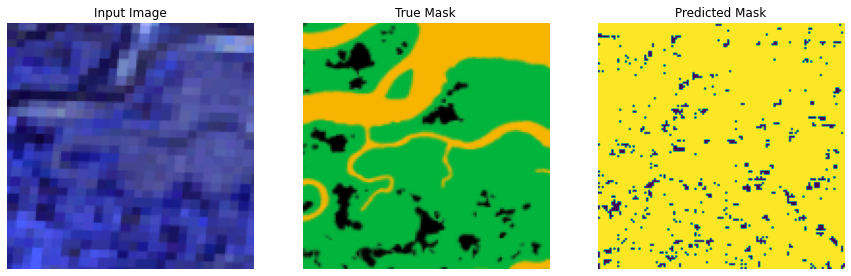

In [58]:
for patch,mask in test_dataset.skip(20).take(1):
    sample_image,sample_mask = patch, mask
    show_predictions()

In [60]:
display([sample_image, sample_mask,
             create_mask(model.predict(gray_marsh[tf.newaxis, ...]))])

NameError: name 'gray_marsh' is not defined

In [78]:
marsh_tensor = tf.convert_to_tensor(marsh_images_gray, dtype =tf.float32)/255.0
marsh_tensor.shape
marsh_tensor = tf.transpose(marsh_tensor, perm=[1,2,0])
marsh_tensor = tf.reshape(marsh_tensor,[1,700,700,11])
marsh_tensor.shape

TensorShape([1, 700, 700, 11])

In [77]:
#display([sample_image, sample_mask,create_mask(model.predict(marsh_tensor[tf.newaxis, ...]))])
model.predict(marsh_tensor)

ValueError: in user code:

    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 1586, in predict_function  *
        return step_function(self, iterator)
    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 1576, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 1569, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 1537, in predict_step
        return self(x, training=False)
    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1020, in __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/input_spec.py", line 266, in assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_9: expected shape=(None, 128, 128, 11), found shape=(None, None, 700, None)


In [80]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 11 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 3)  36          input_10[0][0]                   
__________________________________________________________________________________________________
model_8 (Functional)            [(None, 64, 64, 96), 1841984     conv2d_4[0][0]                   
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 8, 8, 512)    1476608     model_8[0][4]                    
____________________________________________________________________________________________

In [108]:
def change_model(model, new_input_shape=(None, 40, 40, 3),custom_objects=None):
    # replace input shape of first layer
    
    config = model.layers[0].get_config()
    print(config)
    config['batch_input_shape']=new_input_shape
    print(config)
    model.layers[0]=model.layers[0].from_config(config)
    config = model.layers[0].get_config()
    print(config)

    # rebuild model architecture by exporting and importing via json
    new_model = tf.keras.models.model_from_json(model.to_json(),custom_objects=custom_objects)

    # copy weights from old model to new one
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model

In [109]:
resized_model = change_model(model, new_input_shape=(None, 700, 700, 11))

{'batch_input_shape': (None, 128, 128, 11), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_10'}
{'batch_input_shape': (None, 700, 700, 11), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_10'}
{'batch_input_shape': (None, 128, 128, 11), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_10'}
Loaded layer input_10
Loaded layer conv2d_4
Loaded layer model_8
Loaded layer sequential_12
Loaded layer concatenate_16
Loaded layer sequential_13
Loaded layer concatenate_17
Loaded layer sequential_14
Loaded layer concatenate_18
Loaded layer sequential_15
Loaded layer concatenate_19
Loaded layer conv2d_transpose_20


In [100]:
model.layers[0].get_config()

{'batch_input_shape': (None, 128, 128, 11),
 'dtype': 'float32',
 'sparse': False,
 'ragged': False,
 'name': 'input_10'}

In [92]:
resized_model.predict(marsh_tensor)

ValueError: in user code:

    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 1586, in predict_function  *
        return step_function(self, iterator)
    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 1576, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 1569, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/training.py", line 1537, in predict_step
        return self(x, training=False)
    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1020, in __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    File "/Users/Cole/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/engine/input_spec.py", line 266, in assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_9: expected shape=(None, 128, 128, 11), found shape=(None, 700, 700, 11)


In [110]:
resized_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 11 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 3)  36          input_10[0][0]                   
__________________________________________________________________________________________________
model_8 (Functional)            [(None, 64, 64, 96), 1841984     conv2d_4[0][0]                   
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 8, 8, 512)    1476608     model_8[0][4]                    
____________________________________________________________________________________________

In [107]:
#model._layers[0].get_config()

AttributeError: 'Functional' object has no attribute '_layers'

In [114]:
input_layer = tf.keras.layers.Input(shape=[None,700,700,11], name="input_1")
model.layers[0]=input_layer

In [115]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 11 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 3)  36          input_10[0][0]                   
__________________________________________________________________________________________________
model_8 (Functional)            [(None, 64, 64, 96), 1841984     conv2d_4[0][0]                   
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 8, 8, 512)    1476608     model_8[0][4]                    
____________________________________________________________________________________________